# ทำนายโอกาสการผิดนัดชำระหนี้ของลูกค้าบัตรเครดิตในไต้หวันโดยแบบจำลอง Support Vector Machines

In [30]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [148]:
from deap import base, creator, tools, algorithms
import random

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
from imblearn.over_sampling import SMOTE
from collections import Counter

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [164]:
from sklearn.preprocessing import MinMaxScaler

In [162]:
from imblearn.under_sampling import RandomUnderSampler

In [202]:
from imblearn.combine import SMOTEENN 

# 1. จัดเตรียมข้อมูลสำหรับใช้ในการสร้างแบบจำลอง Support Vector Machines

In [109]:
df = pd.read_csv('/Users/1hundredeyes/default_of_credit_card_clients(1).csv')

1.1 จัดการค่าที่หายไป (Handle Missing Values)

* แก้ไข Index ให้เป็น ID เพื่อให้สะดวกต่อการวิเคราะห์

In [111]:
df.set_index("ID", inplace = True)

* ตรวจสอบค่า Null ของข้อมูล

In [59]:
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

* ตรวจสอบข้อมูลในตัวแปร EDUCATION และ MARRIAGE

In [113]:
df['EDUCATION'].value_counts().sort_index(ascending = True)

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [115]:
df['MARRIAGE'].value_counts().sort_index(ascending = True)

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

จากตัวแปรอิระ EDUCATION พบค่าที่ไม่สามารถอธิบายความหมายของข้อมูล ได้แก่ 0, 5, 6 และตัวแปรอิระ MARRIAGE พบค่าที่ไม่สามารถอธิบายความหมายของข้อมูล ได้แก่ 0

* ซึ่งผู้วิจัยได้ทำการแก้ไขปัญหาดังกล่าว โดยแทนค่า 0, 5, 6 ที่มาจากตัวแปรอิระ EDUCATION เป็น 'others' และแทนค่า 0 ที่มาจากตัวแปรอิระ MARRIAGE เป็น 'others'

In [117]:
def impute_education(cols):
    EDUCATION = cols.iloc[0] 

    if EDUCATION not in [1, 2, 3, 4]:
        return 4
    else:
        return EDUCATION

In [119]:
df['EDUCATION'] = df[['EDUCATION']].apply(impute_education,axis=1)

In [121]:
def impute_marriage(cols):
    MARRIAGE = cols.iloc[0] 

    if MARRIAGE not in [1, 2, 3]:
        return 3
    else:
        return MARRIAGE

In [123]:
df['MARRIAGE'] = df[['MARRIAGE']].apply(impute_marriage,axis=1)

* เปลี่ยนชื่อตัวแปรตาม default payment next month เป็น DEFAULT เพื่อให้สะดวกในการวิเคราะห์ข้อมูล

In [125]:
df = df.rename(columns = {'default payment next month': 'DEFAULT'})

* เปลี่ยนชื่อตัวแปรอิสระ PAY_0 เป็น PAY_1 เพื่อให้สอดคล้องกับข้อมูลดังกล่าว

In [127]:
df = df.rename(columns = {'PAY_0': 'PAY_1'})

1.2 การปรับสมดุลข้อมูล (Handle Class Imbalance)

* เนื่องจากข้อมูลมีจำนวน class 1 และ 0 ที่แตกต่างกันมาก จึงต้องทำการปรับสมดุลข้อมูลด้วยเทคนิคผสม (SMOTE + Undersampling)

In [131]:
x = df.drop('DEFAULT',axis=1)

In [133]:
y = df['DEFAULT']

In [254]:
smote_enn = SMOTEENN(random_state=101)
x_resampled, y_resampled = smote_enn.fit_resample(x, y)

print(Counter(y_resampled))

Counter({1: 17031, 0: 10394})


1.3 แบ่งชุดข้อมูล (Train-Test Split)

* แบ่งข้อมูลที่ใช้ในการวิเคราะห์ออกเป็น 2 ส่วน โดยในส่วนแรกเป็นข้อมูลที่ใช้ในการสร้างโมเดล(Traning Data) ซึ่งเป็นร้อยละ 70 ของข้อมูลทั้งหมด และในส่วนที่สองเป็นข้อมูลที่ใช้ในการทดสอบประสิทธิภาพในการทำนายค่าของโมเดล(Testing Data) ซึ่งเป็นร้อยละ 30 ของข้อมูลทั้งหมด

In [208]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.30, random_state=101, stratify = y_resampled)

* พล็อตกราฟระหว่างสถานะการชำระเงิน และฟีเจอร์ โดยการปรับฟีเจอร์ให้เป็น 2 มิติ  

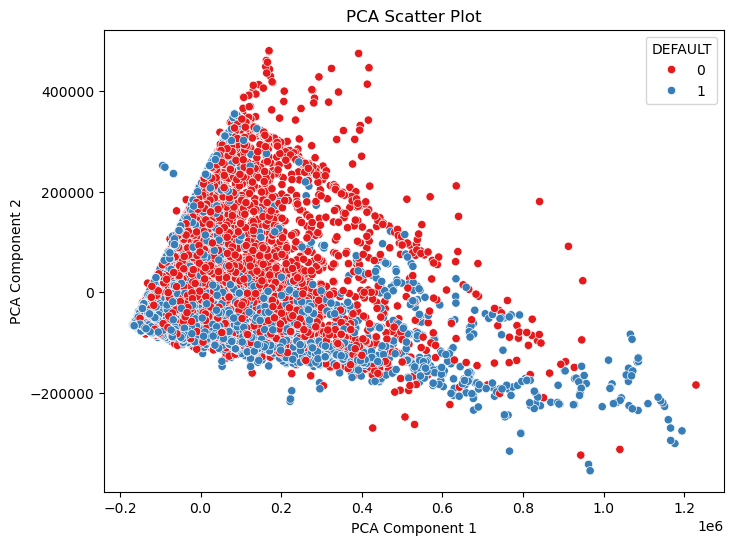

In [210]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)

plt.figure(figsize=(8,6))
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=y_train, palette='Set1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Scatter Plot')
plt.show()

1.4 การปรับขนาดข้อมูล (Feature Scaling)

* เนื่องจากข้อมูลในแต่ละฟีเจอร์มีขนาดที่แตกต่างกันมาก ผู้วิจัยจึงทำการปรับขนาดของฟีเจอร์โดยใช้วิธี StandardScaler

In [236]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [238]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

# 2. สร้างแบบจำลอง Support Vector Machines 

* ทำการสร้างโมเดล Support Vector Machines โดยใช้ฟีเจอร์ที่ผ่านการปรับสมดุลข้อมูลด้วยเทคนิคผสม (SMOTE + Undersampling)และปรับขนาดของฟีเจอร์โดยใช้วิธี StandardScaler

In [240]:
svc_model = SVC()

In [242]:
svc_model.fit(x_train_scaled,y_train)

SVC()

In [244]:
predict = svc_model.predict(x_test_scaled)

In [245]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      3118
           1       0.84      0.88      0.86      5110

    accuracy                           0.82      8228
   macro avg       0.82      0.80      0.81      8228
weighted avg       0.82      0.82      0.82      8228



# 3. ปรับปรุงแบบจำลอง Support Vector Machines โดยใช้ Grid Search ในการค้าหาไฮเปอร์พารามิเตอร์ที่เหมาะสมมากที่สุด¶

In [267]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [269]:
grid = GridSearchCV(svc_model, param_grid, refit=True, verbose=2)
grid.fit(x_train_scaled,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  18.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  17.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  18.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  17.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  17.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  14.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.6s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  12.8s
[CV] END ......................C=0.1, gamma=0.0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

# 4. ทดสอบประสิทธิภาพในการทำนายค่าของแบบจำลอง Support Vector Machines

* ทดสอบประสิทธิภาพในการทำนายโอกาสการผิดนัดชำระหนี้ของลูกค้าบัตรเครดิตในไต้หวันโดยโมเดล Support Vector Machines จากชุดข้อมูล Testing Data

In [271]:
grid_predictions = grid.predict(x_test_scaled)

In [273]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      3118
           1       0.87      0.90      0.88      5110

    accuracy                           0.85      8228
   macro avg       0.84      0.83      0.84      8228
weighted avg       0.85      0.85      0.85      8228



จากผลการทดสอบประสิทธิภาพในการทำนายโอกาสการผิดนัดชำระหนี้ของลูกค้าบัตรเครดิตในไต้หวันโดยโมเดล Support Vector Machines พบว่ามีค่า Accuracy เท่ากับ 0.85% หมายความว่าโมเดลมีประสิทธิภาพในการทำนายที่แม่นยำ 85%

และถ้าหากวิเคราะห์จากค่า Precision และค่า Recall ของโอกาสที่ลูกค้าจะผิดนัดชำระหนี้บัตรเครดิต และโอกาสที่ลูกค้าจะไม่ผิดนัดชำระหนี้บัตรเครดิต พบว่าโมเดล Support Vector Machines มีความสามารถในการทำนายค่าของกลุ่มลูกค้าที่ไม่ผิดนัดชำระหนี้บัตรเครดิตได้แม่นยำ 82% และมีความสามารถในการ Recall ของกลุ่มลูกค้าที่ไม่ผิดนัดชำระหนี้บัตรเครดิต 77% และมีความสามารถในการทำนายค่าของกลุ่มลูกค้าที่มีการผิดนัดชำระหนี้บัตรเครดิตได้แม่นยำ 87% และมีความสามารถในการ Recall ของกลุ่มลูกค้าที่มีการผิดนัดชำระหนี้บัตรเครดิต 90%